In [1]:
!pip install ucimlrepo shap xgboost seaborn matplotlib scikit-learn pandas numpy --quiet


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import shap
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")
print(f"SHAP version: {shap.__version__}")
print(f"XGBoost version: {XGBClassifier().__class__.__module__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


Libraries imported successfully!
SHAP version: 0.48.0
XGBoost version: xgboost.sklearn
Pandas version: 2.2.2
NumPy version: 2.0.2


In [6]:
# Load the UCI Heart Disease dataset
from ucimlrepo import fetch_ucirepo

# Fetch dataset
heart_disease = fetch_ucirepo(id=45)

# Data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

print("Dataset loaded successfully!")
print(f"Features shape: {X.shape}")
print(f"Targets shape: {y.shape}")
print(f"\nFeature columns: {list(X.columns)}")
print(f"\nTarget column: {list(y.columns)}")
print(f"\nTarget unique values: {y['num'].unique()}")

Dataset loaded successfully!
Features shape: (303, 13)
Targets shape: (303, 1)

Feature columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

Target column: ['num']

Target unique values: [0 2 1 3 4]


In [7]:
df = pd.concat([X, y], axis=1)

print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows:")
display(df.head())

print("\nDataset Info:")
print(df.info())

print(f"\nMissing values per column:")
print(df.isnull().sum())

print(f"\nBasic statistics:")
display(df.describe())

Dataset Overview:
Shape: (303, 14)
Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

First 5 rows:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB
None

Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
tha

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [8]:
print("Handling missing values and preprocessing...")

# Check missing values in detail
print("Missing values before handling:")
print(df.isnull().sum())

# For 'ca' (number of major vessels): fill with mode (most common value)
ca_mode = df['ca'].mode()[0]
df['ca'] = df['ca'].fillna(ca_mode)

# For 'thal': fill with mode
thal_mode = df['thal'].mode()[0]
df['thal'] = df['thal'].fillna(thal_mode)

print(f"\nFilled 'ca' missing values with mode: {ca_mode}")
print(f"Filled 'thal' missing values with mode: {thal_mode}")

# Convert target to binary classification (0: no disease, 1: disease present)
# Original: 0 = no disease, 1,2,3,4 = disease present
df['target'] = (df['num'] > 0).astype(int)

print(f"\nTarget variable distribution:")
print(df['target'].value_counts())
print(f"Target distribution (percentage):")
print(df['target'].value_counts(normalize=True) * 100)

print(f"\nMissing values after handling:")
print(df.isnull().sum())

Handling missing values and preprocessing...
Missing values before handling:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64

Filled 'ca' missing values with mode: 0.0
Filled 'thal' missing values with mode: 3.0

Target variable distribution:
target
0    164
1    139
Name: count, dtype: int64
Target distribution (percentage):
target
0    54.125413
1    45.874587
Name: proportion, dtype: float64

Missing values after handling:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
target      0
dtype: int64


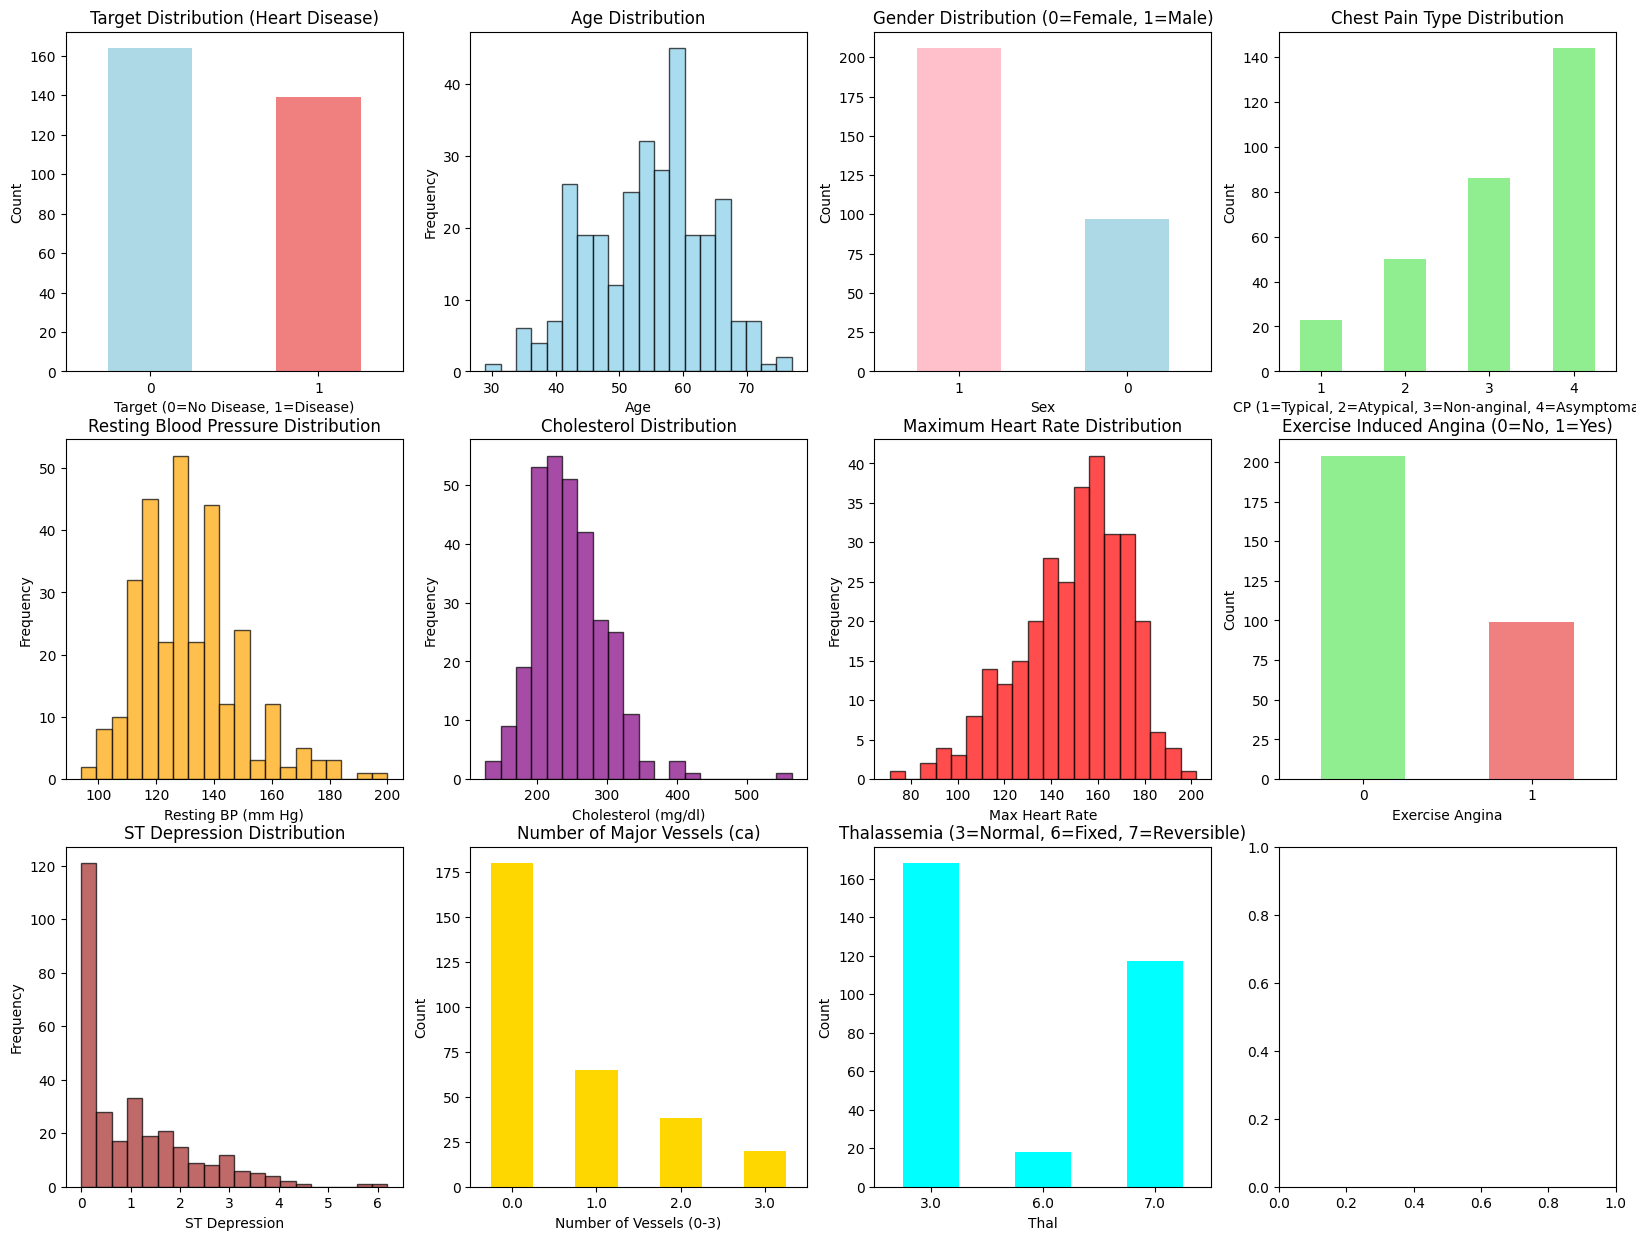

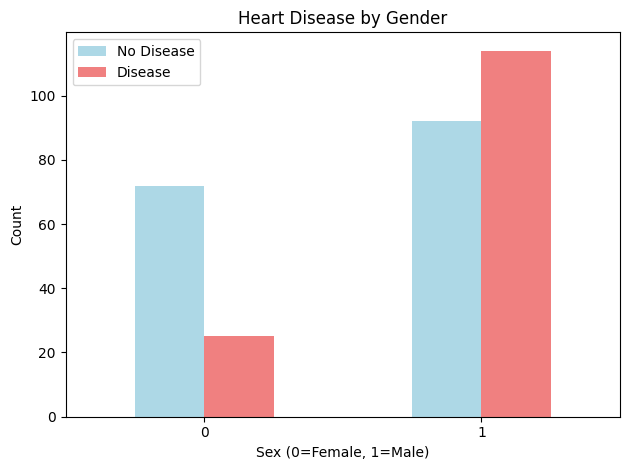

In [9]:
plt.figure(figsize=(20, 15))

# 1. Target distribution
plt.subplot(3, 4, 1)
df['target'].value_counts().plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Target Distribution (Heart Disease)')
plt.xlabel('Target (0=No Disease, 1=Disease)')
plt.ylabel('Count')
plt.xticks(rotation=0)

# 2. Age distribution
plt.subplot(3, 4, 2)
plt.hist(df['age'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

# 3. Gender distribution
plt.subplot(3, 4, 3)
df['sex'].value_counts().plot(kind='bar', color=['pink', 'lightblue'])
plt.title('Gender Distribution (0=Female, 1=Male)')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks(rotation=0)

# 4. Chest Pain Type distribution
plt.subplot(3, 4, 4)
df['cp'].value_counts().sort_index().plot(kind='bar', color='lightgreen')
plt.title('Chest Pain Type Distribution')
plt.xlabel('CP (1=Typical, 2=Atypical, 3=Non-anginal, 4=Asymptomatic)')
plt.ylabel('Count')
plt.xticks(rotation=0)

# 5. Resting Blood Pressure
plt.subplot(3, 4, 5)
plt.hist(df['trestbps'], bins=20, alpha=0.7, color='orange', edgecolor='black')
plt.title('Resting Blood Pressure Distribution')
plt.xlabel('Resting BP (mm Hg)')
plt.ylabel('Frequency')

# 6. Cholesterol
plt.subplot(3, 4, 6)
plt.hist(df['chol'], bins=20, alpha=0.7, color='purple', edgecolor='black')
plt.title('Cholesterol Distribution')
plt.xlabel('Cholesterol (mg/dl)')
plt.ylabel('Frequency')

# 7. Maximum Heart Rate
plt.subplot(3, 4, 7)
plt.hist(df['thalach'], bins=20, alpha=0.7, color='red', edgecolor='black')
plt.title('Maximum Heart Rate Distribution')
plt.xlabel('Max Heart Rate')
plt.ylabel('Frequency')

# 8. Exercise Induced Angina
plt.subplot(3, 4, 8)
df['exang'].value_counts().plot(kind='bar', color=['lightgreen', 'lightcoral'])
plt.title('Exercise Induced Angina (0=No, 1=Yes)')
plt.xlabel('Exercise Angina')
plt.ylabel('Count')
plt.xticks(rotation=0)

# 9. ST Depression
plt.subplot(3, 4, 9)
plt.hist(df['oldpeak'], bins=20, alpha=0.7, color='brown', edgecolor='black')
plt.title('ST Depression Distribution')
plt.xlabel('ST Depression')
plt.ylabel('Frequency')

# 10. Number of Major Vessels
plt.subplot(3, 4, 10)
df['ca'].value_counts().sort_index().plot(kind='bar', color='gold')
plt.title('Number of Major Vessels (ca)')
plt.xlabel('Number of Vessels (0-3)')
plt.ylabel('Count')
plt.xticks(rotation=0)

# 11. Thal (Thalassemia)
plt.subplot(3, 4, 11)
df['thal'].value_counts().sort_index().plot(kind='bar', color='cyan')
plt.title('Thalassemia (3=Normal, 6=Fixed, 7=Reversible)')
plt.xlabel('Thal')
plt.ylabel('Count')
plt.xticks(rotation=0)

# 12. Heart Disease by Gender
plt.subplot(3, 4, 12)
pd.crosstab(df['sex'], df['target']).plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Heart Disease by Gender')
plt.xlabel('Sex (0=Female, 1=Male)')
plt.ylabel('Count')
plt.legend(['No Disease', 'Disease'])
plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig('data_exploration.png', dpi=300, bbox_inches='tight')
plt.show()

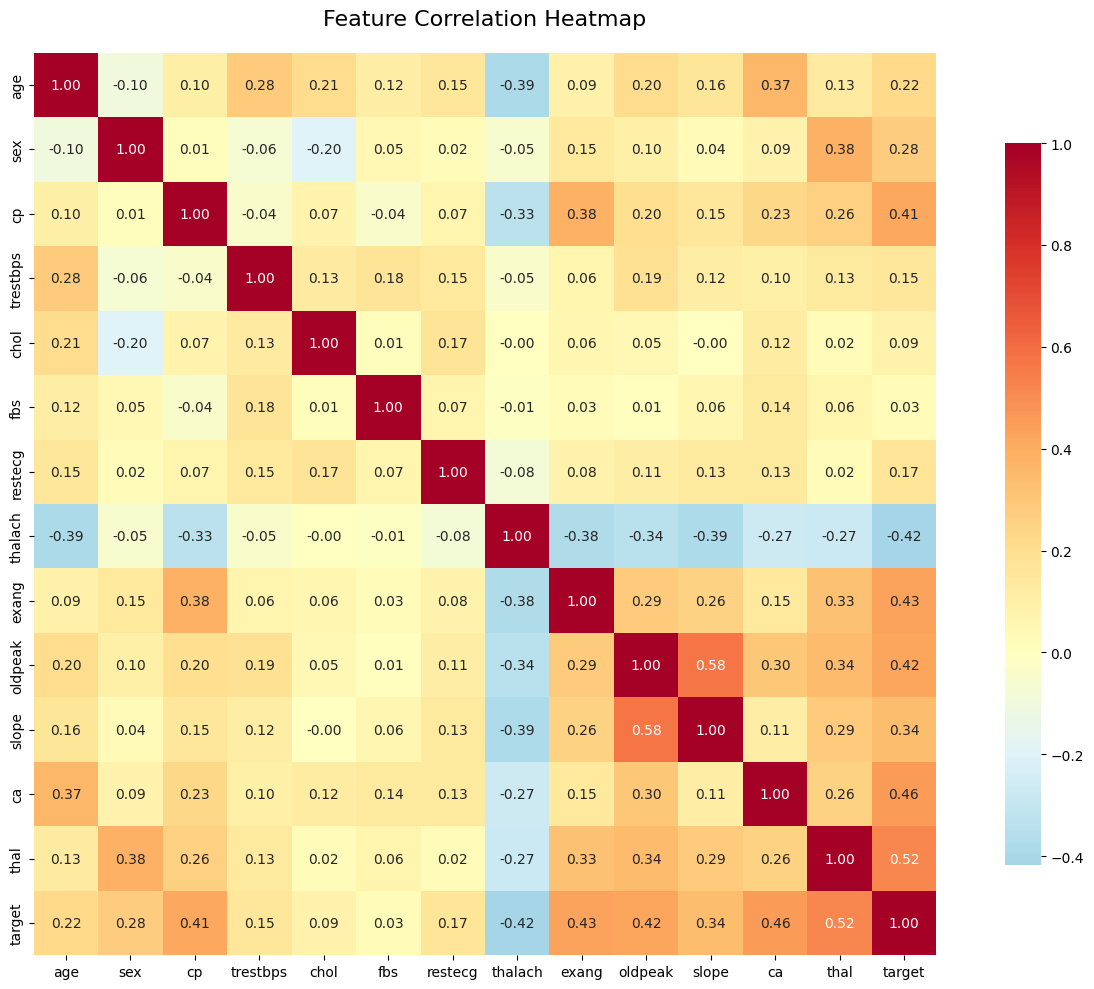

Correlation analysis:
Top correlations with target:
thal        0.522057
ca          0.460033
exang       0.431894
oldpeak     0.424510
thalach     0.417167
cp          0.414446
slope       0.339213
sex         0.276816
age         0.223120
restecg     0.169202
trestbps    0.150825
chol        0.085164
fbs         0.025264
Name: target, dtype: float64


In [10]:
plt.figure(figsize=(14, 10))

# Select feature columns (excluding 'num' as it's the original target)
feature_cols = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

correlation_matrix = df[feature_cols].corr()

# Create heatmap
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='RdYlBu_r',
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8})

plt.title('Feature Correlation Heatmap', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Correlation analysis:")
print("Top correlations with target:")
target_corr = correlation_matrix['target'].abs().sort_values(ascending=False)
print(target_corr[target_corr.index != 'target'])

In [11]:
feature_columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                   'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

X = df[feature_columns].copy()
y = df['target'].copy()

print("Features and target prepared:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Feature columns: {list(X.columns)}")
print(f"Target distribution: {y.value_counts().to_dict()}")

# Check for any remaining missing values
print(f"\nMissing values in features: {X.isnull().sum().sum()}")
print(f"Missing values in target: {y.isnull().sum()}")

# Display feature types
print(f"\nFeature data types:")
print(X.dtypes)

Features and target prepared:
X shape: (303, 13)
y shape: (303,)
Feature columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Target distribution: {0: 164, 1: 139}

Missing values in features: 0
Missing values in target: 0

Feature data types:
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca          float64
thal        float64
dtype: object


In [12]:

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data split completed:")
print(f"Training set: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Testing set: X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

print(f"\nTraining set target distribution:")
print(y_train.value_counts(normalize=True) * 100)

print(f"\nTesting set target distribution:")
print(y_test.value_counts(normalize=True) * 100)

Data split completed:
Training set: X_train shape: (242, 13), y_train shape: (242,)
Testing set: X_test shape: (61, 13), y_test shape: (61,)

Training set target distribution:
target
0    54.132231
1    45.867769
Name: proportion, dtype: float64

Testing set target distribution:
target
0    54.098361
1    45.901639
Name: proportion, dtype: float64


In [13]:
# Standardize the features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed!")
print(f"Original feature ranges (training set):")
print(f"Min: {X_train.min()}")
print(f"Max: {X_train.max()}")

print(f"\nScaled feature ranges:")
print(f"Min: {X_train_scaled.min():.3f}")
print(f"Max: {X_train_scaled.max():.3f}")
print(f"Mean: {X_train_scaled.mean():.3f}")
print(f"Std: {X_train_scaled.std():.3f}")

Feature scaling completed!
Original feature ranges (training set):
Min: age          29.0
sex           0.0
cp            1.0
trestbps     94.0
chol        126.0
fbs           0.0
restecg       0.0
thalach      71.0
exang         0.0
oldpeak       0.0
slope         1.0
ca            0.0
thal          3.0
dtype: float64
Max: age          77.0
sex           1.0
cp            4.0
trestbps    200.0
chol        564.0
fbs           1.0
restecg       2.0
thalach     202.0
exang         1.0
oldpeak       6.2
slope         3.0
ca            3.0
thal          7.0
dtype: float64

Scaled feature ranges:
Min: -3.488
Max: 5.957
Mean: -0.000
Std: 1.000


In [14]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

# Train models and store results
model_results = {}
trained_models = {}

print("Training models...")
print("="*50)

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Use scaled data for Logistic Regression, original for tree-based models
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Store results
    model_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    # Store trained model
    trained_models[name] = model

    print(f"✅ {name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")

print("\n" + "="*50)
print("All models trained successfully!")

Training models...

Training Random Forest...
✅ Random Forest - Accuracy: 0.8852, F1: 0.8814, ROC-AUC: 0.9518

Training XGBoost...
✅ XGBoost - Accuracy: 0.8525, F1: 0.8525, ROC-AUC: 0.9188

Training Logistic Regression...
✅ Logistic Regression - Accuracy: 0.8689, F1: 0.8667, ROC-AUC: 0.9513

All models trained successfully!


In [15]:
results_df = pd.DataFrame(model_results).T
results_df = results_df.drop(['predictions', 'probabilities'], axis=1)

print("Model Performance Comparison:")
print("="*60)
display(results_df.round(4))

# Find best model based on ROC-AUC score
best_model_name = results_df['roc_auc'].idxmax()
best_model = trained_models[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"Best ROC-AUC Score: {results_df.loc[best_model_name, 'roc_auc']:.4f}")

# Detailed classification report for best model
print(f"\nDetailed Classification Report for {best_model_name}:")
print("="*60)
y_pred_best = model_results[best_model_name]['predictions']
print(classification_report(y_test, y_pred_best, target_names=['No Disease', 'Disease']))


Model Performance Comparison:


,accuracy,precision,recall,f1_score,roc_auc
Random Forest,0.885246,0.83871,0.928571,0.881356,0.95184
XGBoost,0.852459,0.787879,0.928571,0.852459,0.918831
Logistic Regression,0.868852,0.8125,0.928571,0.866667,0.951299



🏆 Best Model: Random Forest
Best ROC-AUC Score: 0.9518

Detailed Classification Report for Random Forest:
              precision    recall  f1-score   support

  No Disease       0.93      0.85      0.89        33
     Disease       0.84      0.93      0.88        28

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



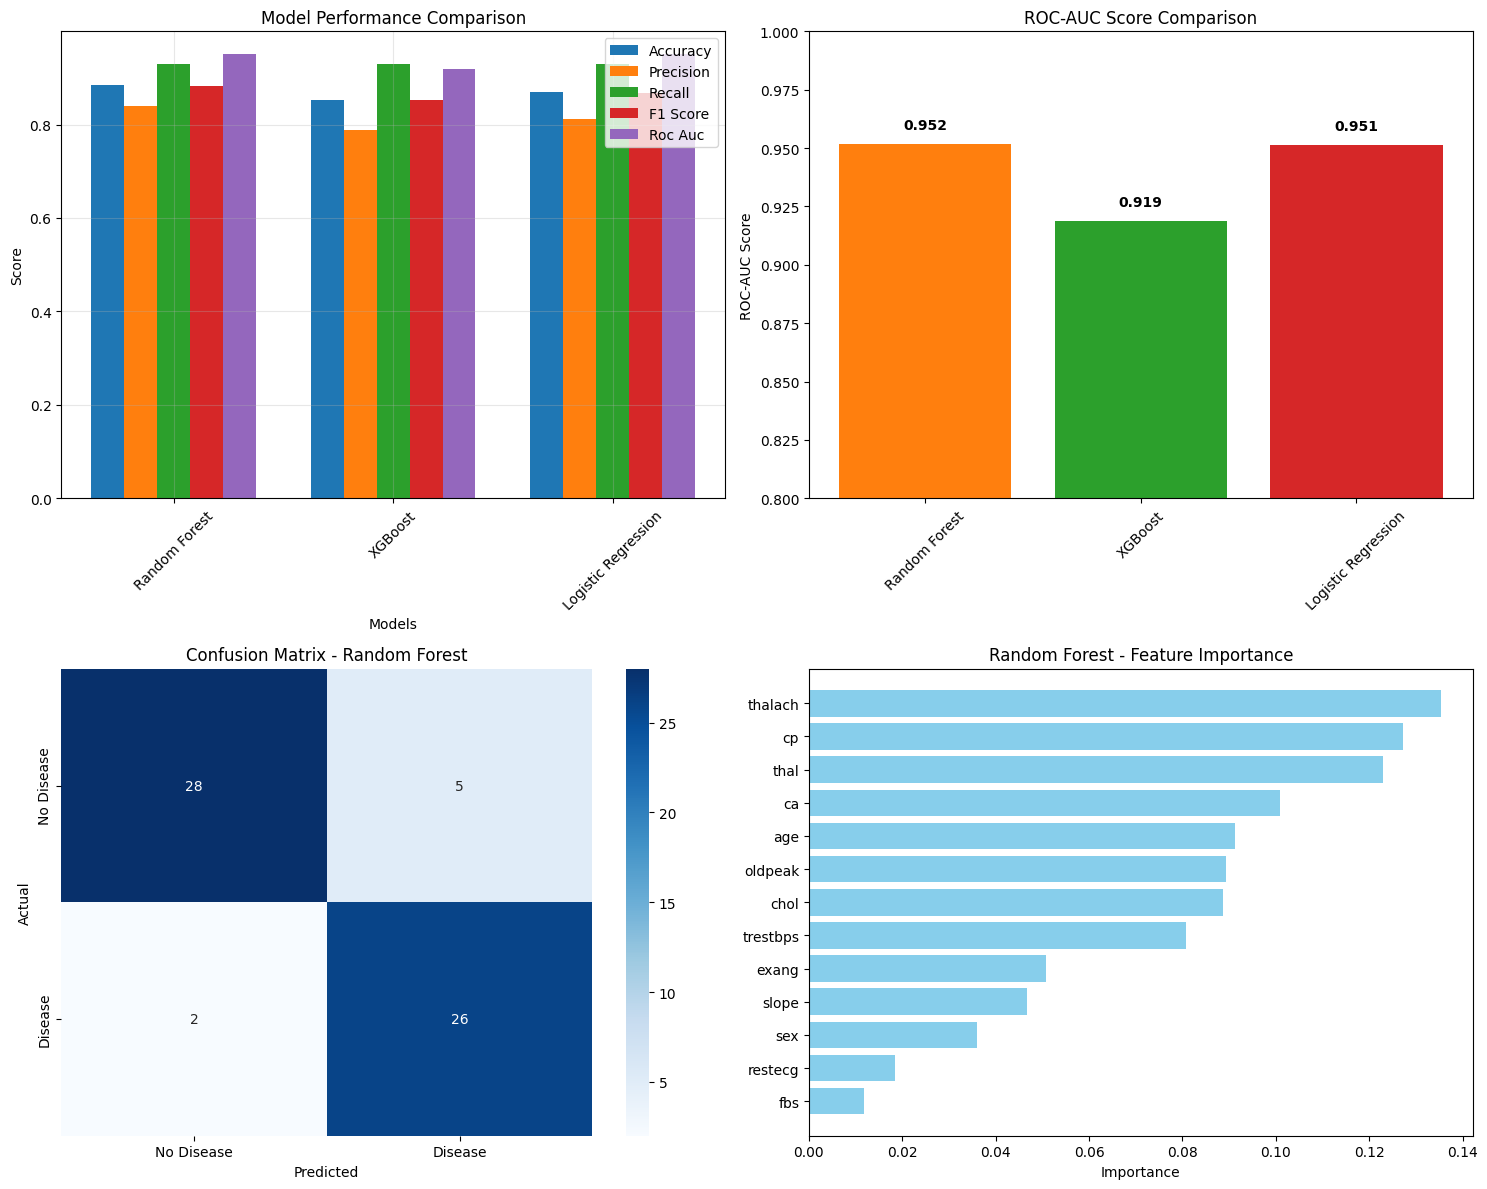

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Model Comparison Bar Chart
ax1 = axes[0, 0]
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
x = np.arange(len(results_df.index))
width = 0.15

for i, metric in enumerate(metrics):
    ax1.bar(x + i * width, results_df[metric], width,
            label=metric.replace('_', ' ').title())

ax1.set_xlabel('Models')
ax1.set_ylabel('Score')
ax1.set_title('Model Performance Comparison')
ax1.set_xticks(x + width * 2)
ax1.set_xticklabels(results_df.index, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. ROC-AUC Comparison
ax2 = axes[0, 1]
colors = ['#ff7f0e', '#2ca02c', '#d62728']
bars = ax2.bar(results_df.index, results_df['roc_auc'], color=colors)
ax2.set_title('ROC-AUC Score Comparison')
ax2.set_ylabel('ROC-AUC Score')
ax2.set_ylim(0.8, 1.0)
plt.setp(ax2.get_xticklabels(), rotation=45)

# Add value labels on bars
for bar, value in zip(bars, results_df['roc_auc']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. Confusion Matrix for Best Model
ax3 = axes[1, 0]
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
ax3.set_title(f'Confusion Matrix - {best_model_name}')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')

# 4. Feature Importance for Random Forest
ax4 = axes[1, 1]
if best_model_name in ['Random Forest', 'XGBoost']:
    feature_importance = best_model.feature_importances_
    feature_names = X.columns

    # Sort features by importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=True)

    ax4.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
    ax4.set_title(f'{best_model_name} - Feature Importance')
    ax4.set_xlabel('Importance')
else:
    ax4.text(0.5, 0.5, f'{best_model_name}\nFeature Importance\nNot Available',
             ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Feature Importance')

plt.tight_layout()
plt.savefig('model_performance.png', dpi=300, bbox_inches='tight')
plt.show()


=== SHAP Explanations ===
Generating SHAP explanations for the best model: Random Forest
SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (61, 13, 2)
Expected value: [0.53842975 0.46157025]
SHAP values computed successfully!
SHAP values for plot shape: (61, 13)
Expected value for plot: 0.46157024793388446
Expected value type: <class 'numpy.float64'>


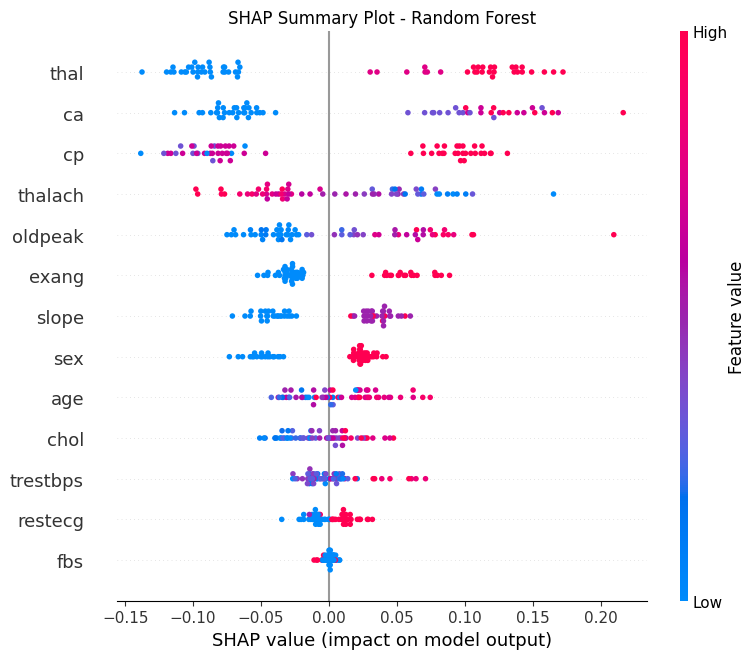

SHAP values for first instance shape: (13,)
Features for first instance shape: (13,)


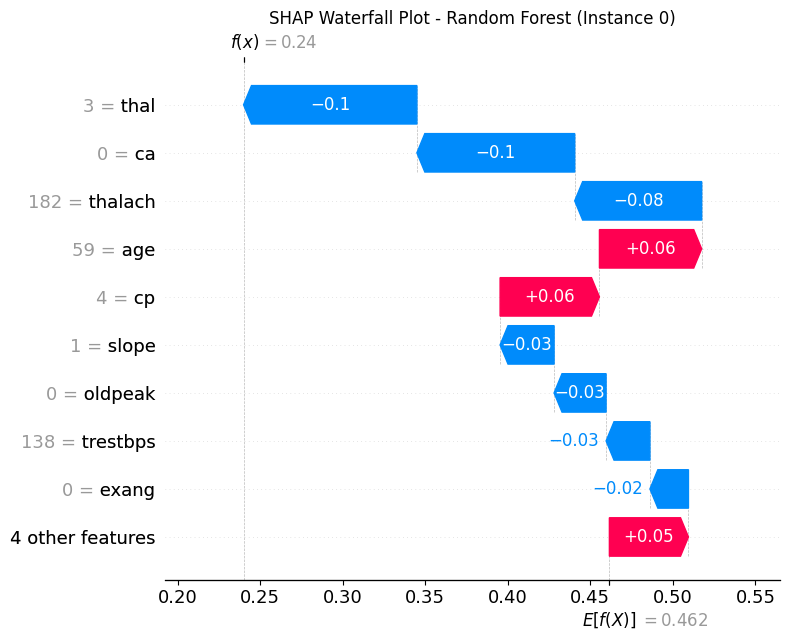

In [17]:
print("\n=== SHAP Explanations ===")
print(f"Generating SHAP explanations for the best model: {best_model_name}")

# Select appropriate SHAP explainer based on model type
if best_model_name in ['Random Forest', 'XGBoost']:
    explainer = shap.TreeExplainer(best_model)
    # For tree models, use original X_test
    shap_values = explainer.shap_values(X_test)
    # Debug: Print SHAP values structure
    print(f"SHAP values type: {type(shap_values)}")
    print(f"SHAP values shape: {len(shap_values) if isinstance(shap_values, list) else shap_values.shape}")
    print(f"Expected value: {explainer.expected_value}")
    # For binary classification, select SHAP values for the positive class (class 1)
    if isinstance(shap_values, list):  # XGBoost returns list for binary
        shap_values_for_plot = shap_values[1]  # Positive class
        expected_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
    else:  # Random Forest
        # Handle Random Forest: check if shap_values is 3D (samples, features, classes)
        if shap_values.ndim == 3:
            shap_values_for_plot = shap_values[:, :, 1]  # Positive class
        else:
            shap_values_for_plot = shap_values  # Already for binary classification
        expected_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
elif best_model_name == 'Logistic Regression':
    explainer = shap.LinearExplainer(best_model, X_train_scaled, feature_dependence="correlation")
    # For linear models, use scaled X_test
    shap_values = explainer.shap_values(X_test_scaled)
    shap_values_for_plot = shap_values  # Single array for binary classification
    expected_value = explainer.expected_value
    # Debug: Print SHAP values structure
    print(f"SHAP values type: {type(shap_values)}")
    print(f"SHAP values shape: {shap_values.shape}")
    print(f"Expected value: {explainer.expected_value}")
else:
    # Fallback to KernelExplainer (unlikely to be used)
    explainer = shap.KernelExplainer(best_model.predict_proba, X_train_scaled)
    shap_values = explainer.shap_values(X_test_scaled)
    shap_values_for_plot = shap_values[1]  # Positive class
    expected_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
    # Debug: Print SHAP values structure
    print(f"SHAP values type: {type(shap_values)}")
    print(f"SHAP values shape: {len(shap_values) if isinstance(shap_values, list) else shap_values.shape}")
    print(f"Expected value: {explainer.expected_value}")

print("SHAP values computed successfully!")
print(f"SHAP values for plot shape: {shap_values_for_plot.shape}")
print(f"Expected value for plot: {expected_value}")
print(f"Expected value type: {type(expected_value)}")

# 1. Summary plot - overall feature importance
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_for_plot, X_test if best_model_name != 'Logistic Regression' else X_test_scaled,
                  feature_names=X.columns, show=False)
plt.title(f'SHAP Summary Plot - {best_model_name}')
plt.tight_layout()
plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Force plot - individual prediction explanation (for the first test instance)
shap.initjs()
print(f"SHAP values for first instance shape: {shap_values_for_plot[0].shape}")
print(f"Features for first instance shape: {(X_test.iloc[0] if best_model_name != 'Logistic Regression' else X_test_scaled[0]).shape}")
# Create Explanation object for force plot
explanation = shap.Explanation(
    values=shap_values_for_plot[0],  # SHAP values for first instance
    base_values=float(expected_value),  # Ensure scalar base value
    data=X_test.iloc[0] if best_model_name != 'Logistic Regression' else X_test_scaled[0],  # Features
    feature_names=X.columns
)
try:
    force_plot = shap.plots.force(explanation, matplotlib=False)
    display(force_plot)  # Display in notebook
    shap.save_html('shap_force_plot.html', force_plot)
except Exception as e:
    print(f"Error generating force plot: {e}")
    print("Skipping force plot generation.")

# 3. Waterfall plot - step-by-step feature contribution (for the first test instance)
plt.figure(figsize=(10, 8))
# Create Explanation object for waterfall
explanation = shap.Explanation(
    values=shap_values_for_plot[0],
    base_values=float(expected_value),  # Ensure scalar base value
    data=X_test.iloc[0].values if best_model_name != 'Logistic Regression' else X_test_scaled[0],
    feature_names=X.columns
)
try:
    shap.plots.waterfall(explanation, show=False)
    plt.title(f'SHAP Waterfall Plot - {best_model_name} (Instance 0)')
    plt.tight_layout()
    plt.savefig('shap_waterfall_plot.png', dpi=300, bbox_inches='tight')
    plt.show()
except Exception as e:
    print(f"Error generating waterfall plot: {e}")
    print("Skipping waterfall plot generation.")

In [18]:

# Compute mean absolute SHAP values for feature importance
shap_importance = np.abs(shap_values_for_plot).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap': shap_importance
}).sort_values('mean_abs_shap', ascending=False)
print("Top 5 SHAP Features:")
print(shap_importance_df.head(5))

Top 5 SHAP Features:
    feature  mean_abs_shap
12     thal       0.101908
11       ca       0.094215
2        cp       0.091864
7   thalach       0.052706
9   oldpeak       0.050147


In [19]:
if best_model_name in ['Random Forest', 'XGBoost']:
    model_importance = pd.DataFrame({
        'feature': X.columns,
        'model_importance': best_model.feature_importances_
    }).sort_values('model_importance', ascending=False)
    print("Top 5 Model Feature Importance:")
    print(model_importance.head(5))
    print("\nComparison with SHAP:")
    print(pd.merge(shap_importance_df.head(5), model_importance.head(5), on='feature', how='outer'))


Top 5 Model Feature Importance:
    feature  model_importance
7   thalach          0.135404
2        cp          0.127163
12     thal          0.122940
11       ca          0.100811
0       age          0.091327

Comparison with SHAP:
   feature  mean_abs_shap  model_importance
0      age            NaN          0.091327
1       ca       0.094215          0.100811
2       cp       0.091864          0.127163
3  oldpeak       0.050147               NaN
4     thal       0.101908          0.122940
5  thalach       0.052706          0.135404
